# Refactored As Operational Pipeline (with MLRun)

In [1]:
# Install prerequisites
%pip install mlrun lightgbm shapely

Note: you may need to restart the kernel to use updated packages.


## Create an MLRun project and configuration

In [2]:
from os import path
import mlrun

project_name_base = 'nyc-taxi'

project_name, artifact_path = mlrun.set_environment(project=project_name_base, user_project=True)

print(f'Project name: {project_name}')
print(f'Artifact path: {artifact_path}')

Project name: nyc-taxi-admin
Artifact path: v3io:///projects/{{run.project}}/artifacts


## Define Nuclio and MLRun Functions

In [3]:
# mlrun: start-code

In [4]:
from os import path
import numpy as np 
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from pickle import dumps
import shapely.wkt

In [5]:
def get_zones_dict(zones_url):
    zones_df = pd.read_csv(zones_url)
    
    # Remove unecessary fields
    zones_df.drop(['Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough'], axis=1, inplace=True)
    
    # Convert DF to dictionary
    zones_dict = zones_df.set_index('OBJECTID').to_dict('index')
    
    # Add lat/long to each zone
    for zone in zones_dict:
        shape = shapely.wkt.loads(zones_dict[zone]['the_geom'])
        zones_dict[zone]['long'] = shape.centroid.x
        zones_dict[zone]['lat'] = shape.centroid.y
    
    return zones_dict

In [6]:
def get_zone_lat(zones_dict, zone_id):
    return zones_dict[zone_id]['lat']

In [7]:
def get_zone_long(zones_dict, zone_id):
    return zones_dict[zone_id]['long']

In [8]:
def clean_df(df):
    return df[(df.fare_amount > 0)  & (df.fare_amount <= 500) &
             (df.PULocationID > 0) & (df.PULocationID <= 263) & 
             (df.DOLocationID > 0) & (df.DOLocationID <= 263)]

In [9]:
# To Compute Haversine distance
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

In [10]:
def radian_conv(degree):
    """
    Return radian.
    """
    return  np.radians(degree)

In [11]:
def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    dataset['sol_dist'] = pickup_sol + dropoff_sol
    dataset['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return dataset

In [12]:
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['tpep_pickup_datetime'],format="%Y-%m-%d %H:%M:%S")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    return dataset

In [13]:
def fetch_data(context : MLClientCtx, taxi_records_path: DataItem, zones_path: DataItem):
    
    context.logger.info('Reading taxi records data from {}'.format(taxi_records_path))
    taxi_records_dataset = taxi_records_path.as_df()
    
    context.logger.info('Reading zones data from {}'.format(zones_path))
    zones_dataset = zones_path.as_df()
    
    target_path = path.join(context.artifact_path, 'data')
    context.logger.info('Saving datasets to {} ...'.format(target_path))

    # Store the data sets in your artifacts database
    context.log_dataset('nyc-taxi-dataset', df=taxi_records_dataset, format='csv',
                        index=False, artifact_path=target_path)
    context.log_dataset('zones-dataset', df=zones_dataset, format='csv',
                        index=False, artifact_path=target_path)    

In [14]:
def get_zones_dict(zones_df):

    # Remove unecessary fields
    zones_df.drop(['Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough'], axis=1, inplace=True)
    
    # Convert DF to dictionary
    zones_dict = zones_df.set_index('OBJECTID').to_dict('index')
    
    # Add lat/long to each zone
    for zone in zones_dict:
        shape = shapely.wkt.loads(zones_dict[zone]['the_geom'])
        zones_dict[zone]['long'] = shape.centroid.x
        zones_dict[zone]['lat'] = shape.centroid.y
    
    return zones_dict

In [15]:
def get_zone_lat(zones_dict, zone_id):
    return zones_dict[zone_id]['lat']

In [16]:
def get_zone_long(zones_dict, zone_id):
    return zones_dict[zone_id]['long']

In [17]:
def transform_dataset(context : MLClientCtx, taxi_records_path: DataItem, zones_path: DataItem):
    
    context.logger.info('Begin datasets transform')
    
    context.logger.info('zones_path: ' + str(zones_path))
    
    zones_df = zones_path.as_df()    
    
    # Get zones dictionary
    zones_dict = get_zones_dict(zones_df)
    
    train_df = taxi_records_path.as_df()
    
    # Clean DF
    train_df = clean_df(train_df)
    
    # Enrich DF
    train_df['pickup_latitude'] = train_df.apply(lambda x: get_zone_lat(zones_dict, x['PULocationID']), axis=1 )
    train_df['pickup_longitude'] = train_df.apply(lambda x: get_zone_long(zones_dict, x['PULocationID']), axis=1 )
    train_df['dropoff_latitude'] = train_df.apply(lambda x: get_zone_lat(zones_dict, x['DOLocationID']), axis=1 )
    train_df['dropoff_longitude'] = train_df.apply(lambda x: get_zone_long(zones_dict, x['DOLocationID']), axis=1 )

    train_df = add_datetime_info(train_df)
    train_df = add_airport_dist(train_df)

    train_df['pickup_latitude'] = radian_conv(train_df['pickup_latitude'])
    train_df['pickup_longitude'] = radian_conv(train_df['pickup_longitude'])
    train_df['dropoff_latitude'] = radian_conv(train_df['dropoff_latitude'])
    train_df['dropoff_longitude'] = radian_conv(train_df['dropoff_longitude'])

    train_df.drop(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'congestion_surcharge', 'improvement_surcharge', 'pickup_datetime',
                  'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'RatecodeID', 'store_and_fwd_flag',
                  'PULocationID', 'DOLocationID', 'payment_type'], 
                  axis=1, inplace=True, errors='ignore')
    
    # Save dataset to artifact
    target_path = path.join(context.artifact_path, 'data')
    context.log_dataset('nyc-taxi-dataset-transformed', df=train_df, artifact_path=target_path, format='csv')    
    
    context.logger.info('End dataset transform')

In [18]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }

In [19]:
def train_model(context: MLClientCtx, input_ds: DataItem):
    
    context.logger.info('Begin training')
    context.logger.info('LGBM version is ' + str(lgbm.__version__))
    
    train_df = input_ds.as_df()
    
    y = train_df['fare_amount']
  
    train_df = train_df.drop(columns=['fare_amount'])
    train_df = train_df.drop(train_df.columns[[0]], axis=1)
    x_train,x_test,y_train,y_test = train_test_split(train_df,y,random_state=123,test_size=0.10)
    
    train_set = lgbm.Dataset(x_train, y_train, silent=False,categorical_feature=['year','month','day','weekday'])
    valid_set = lgbm.Dataset(x_test, y_test, silent=False,categorical_feature=['year','month','day','weekday'])
    model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)
    
    context.log_model('FareModel',
                     body=dumps(model),
                     artifact_path=context.artifact_subpath("models"),
                     model_file="FareModel.pkl")
    
    context.logger.info('End training')

In [20]:
# mlrun: end-code

## Set Input Paths

In [21]:
taxi_records_csv_path = 'https://s3.wasabisys.com/iguazio/data/Taxi/yellow_tripdata_2019-01_subset.csv'
zones_csv_path = 'https://s3.wasabisys.com/iguazio/data/Taxi/taxi_zones.csv'

## Convert Code to a Function

In [22]:
taxi_func = mlrun.code_to_function(name='taxi',
                                   kind='job',
                                   image='mlrun/mlrun',
                                   requirements=['lightgbm', 'shapely'],
                                   filename='mlrun-code.ipynb')

## Run `fetch_data` Locally

We can test out code locally, by calling the function with `local` parameter set to `True`

In [23]:
fetch_data_run = taxi_func.run(handler='fetch_data',
                               inputs={'taxi_records_path': taxi_records_csv_path,
                                       'zones_path': zones_csv_path},
                               local=True)

> 2021-05-10 11:34:10,720 [info] starting run taxi-fetch_data uid=048ec5ad0231422a9271ff16fdb86073 DB=http://mlrun-api:8080
> 2021-05-10 11:34:10,872 [info] Reading taxi records data from https://s3.wasabisys.com/iguazio/data/Taxi/yellow_tripdata_2019-01_subset.csv
> 2021-05-10 11:34:16,014 [info] Reading zones data from https://s3.wasabisys.com/iguazio/data/Taxi/taxi_zones.csv
> 2021-05-10 11:34:16,530 [info] Saving datasets to v3io:///projects/nyc-taxi-admin/artifacts/data ...


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
nyc-taxi-admin,...fdb86073,0,May 10 11:34:10,completed,taxi-fetch_data,v3io_user=adminkind=owner=adminhost=jupyter-7b878b4fc4-fvpwn,taxi_records_pathzones_path,,,nyc-taxi-datasetzones-dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run 048ec5ad0231422a9271ff16fdb86073 --project nyc-taxi-admin , !mlrun logs 048ec5ad0231422a9271ff16fdb86073 --project nyc-taxi-admin
> 2021-05-10 11:34:23,753 [info] run executed, status=completed


In [24]:
fetch_data_run.outputs

{'nyc-taxi-dataset': 'store://artifacts/nyc-taxi-admin/taxi-fetch_data_nyc-taxi-dataset:048ec5ad0231422a9271ff16fdb86073',
 'zones-dataset': 'store://artifacts/nyc-taxi-admin/taxi-fetch_data_zones-dataset:048ec5ad0231422a9271ff16fdb86073'}

## Run on the Cluster

### Prepare Cluster Function

Create an MLRun function and create a custom image for it (that uses shapely).

In [25]:
from mlrun.platforms import auto_mount
taxi_func.apply(auto_mount())
taxi_func.deploy()

> 2021-05-10 11:34:23,770 [info] starting remote build, image: .mlrun/func-nyc-taxi-admin-taxi:latest
E0510 11:34:46.000249       1 aws_credentials.go:77] while getting AWS credentials NoCredentialProviders: no valid providers in chain. Deprecated.
	For verbose messaging see aws.Config.CredentialsChainVerboseErrors
INFO[0020] Retrieving image manifest mlrun/mlrun:0.6.3-rc12 
INFO[0020] Retrieving image manifest mlrun/mlrun:0.6.3-rc12 
INFO[0021] Built cross stage deps: map[]                
INFO[0021] Retrieving image manifest mlrun/mlrun:0.6.3-rc12 
INFO[0021] Retrieving image manifest mlrun/mlrun:0.6.3-rc12 
INFO[0021] Executing 0 build triggers                   
INFO[0021] Unpacking rootfs as cmd RUN python -m pip install lightgbm shapely requires it. 
INFO[0036] RUN python -m pip install lightgbm shapely   
INFO[0036] Taking snapshot of full filesystem...        
INFO[0067] cmd: /bin/sh                                 
INFO[0067] args: [-c python -m pip install lightgbm shapely] 


True

In [26]:
fetch_data_run = taxi_func.run(name='fetch_data',
                               handler='fetch_data',
                               inputs={'taxi_records_path': taxi_records_csv_path,
                                       'zones_path': zones_csv_path})

> 2021-05-10 11:35:38,804 [info] starting run fetch_data uid=041c97c777fa4e25a06ae027250a0db0 DB=http://mlrun-api:8080
> 2021-05-10 11:35:38,982 [info] Job is running in the background, pod: fetch-data-gt9rc
> 2021-05-10 11:35:44,488 [info] Reading taxi records data from https://s3.wasabisys.com/iguazio/data/Taxi/yellow_tripdata_2019-01_subset.csv
> 2021-05-10 11:35:49,054 [info] Reading zones data from https://s3.wasabisys.com/iguazio/data/Taxi/taxi_zones.csv
> 2021-05-10 11:35:49,201 [info] Saving datasets to v3io:///projects/nyc-taxi-admin/artifacts/data ...
> 2021-05-10 11:35:56,446 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
nyc-taxi-admin,...250a0db0,0,May 10 11:35:44,completed,fetch_data,v3io_user=adminkind=jobowner=adminhost=fetch-data-gt9rc,taxi_records_pathzones_path,,,nyc-taxi-datasetzones-dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run 041c97c777fa4e25a06ae027250a0db0 --project nyc-taxi-admin , !mlrun logs 041c97c777fa4e25a06ae027250a0db0 --project nyc-taxi-admin
> 2021-05-10 11:35:57,289 [info] run executed, status=completed


In [27]:
fetch_data_run.outputs

{'nyc-taxi-dataset': 'store://artifacts/nyc-taxi-admin/fetch_data_nyc-taxi-dataset:041c97c777fa4e25a06ae027250a0db0',
 'zones-dataset': 'store://artifacts/nyc-taxi-admin/fetch_data_zones-dataset:041c97c777fa4e25a06ae027250a0db0'}

## Transform the Dataset

In [28]:
transform_dataset_run = taxi_func.run(name='transform_dataset',
                                      handler='transform_dataset',
                                      inputs={'taxi_records_path': fetch_data_run.outputs['nyc-taxi-dataset'],
                                              'zones_path': fetch_data_run.outputs['zones-dataset']})

> 2021-05-10 11:35:57,306 [info] starting run transform_dataset uid=98a6daef374a4b448f67c434a71c07c1 DB=http://mlrun-api:8080
> 2021-05-10 11:35:57,510 [info] Job is running in the background, pod: transform-dataset-t5v9s
> 2021-05-10 11:36:02,717 [info] Begin datasets transform
> 2021-05-10 11:36:02,718 [info] zones_path: v3io:///projects/nyc-taxi-admin/artifacts/data/zones-dataset.csv
> 2021-05-10 11:36:54,398 [info] End dataset transform
> 2021-05-10 11:36:54,429 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
nyc-taxi-admin,...a71c07c1,0,May 10 11:36:02,completed,transform_dataset,v3io_user=adminkind=jobowner=adminhost=transform-dataset-t5v9s,taxi_records_pathzones_path,,,nyc-taxi-dataset-transformed


to track results use .show() or .logs() or in CLI: 
!mlrun get run 98a6daef374a4b448f67c434a71c07c1 --project nyc-taxi-admin , !mlrun logs 98a6daef374a4b448f67c434a71c07c1 --project nyc-taxi-admin
> 2021-05-10 11:37:02,984 [info] run executed, status=completed


In [29]:
transform_dataset_run.outputs

{'nyc-taxi-dataset-transformed': 'store://artifacts/nyc-taxi-admin/transform_dataset_nyc-taxi-dataset-transformed:98a6daef374a4b448f67c434a71c07c1'}

## Train Model

In [30]:
train_model_run = taxi_func.run(name='train_model',
                                handler='train_model',
                                inputs={'input_ds': transform_dataset_run.outputs['nyc-taxi-dataset-transformed']})

> 2021-05-10 11:37:03,003 [info] starting run train_model uid=1f3fb4da0e4d4dc0b8db3dab4505eb04 DB=http://mlrun-api:8080
> 2021-05-10 11:37:03,216 [info] Job is running in the background, pod: train-model-vfm5h
> 2021-05-10 11:37:08,622 [info] Begin training
> 2021-05-10 11:37:08,622 [info] LGBM version is 3.2.1
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23961
[LightGBM] [Info] Number of data points in the train set: 879294, number of used features: 16
[LightGBM] [Warning] bagging_

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
nyc-taxi-admin,...4505eb04,0,May 10 11:37:08,completed,train_model,v3io_user=adminkind=jobowner=adminhost=train-model-vfm5h,input_ds,,,FareModel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 1f3fb4da0e4d4dc0b8db3dab4505eb04 --project nyc-taxi-admin , !mlrun logs 1f3fb4da0e4d4dc0b8db3dab4505eb04 --project nyc-taxi-admin
> 2021-05-10 11:37:51,704 [info] run executed, status=completed


In [31]:
train_model_run.outputs

{'FareModel': 'store://artifacts/nyc-taxi-admin/train_model_FareModel:1f3fb4da0e4d4dc0b8db3dab4505eb04'}

## Serving

The model serving class is in model-serving.ipynb.

In [32]:
serving = mlrun.code_to_function(filename=path.abspath('model-serving.ipynb')).apply(auto_mount())

serving.spec.default_class = 'LGBMModel'
serving.add_model('taxi-serving', train_model_run.outputs['FareModel'])
serving_address = serving.deploy()

> 2021-05-10 11:37:59,731 [info] Starting remote function deploy
2021-05-10 11:37:59  (info) Deploying function
2021-05-10 11:37:59  (info) Building
2021-05-10 11:37:59  (info) Staging files and preparing base images
2021-05-10 11:37:59  (info) Building processor image
2021-05-10 11:38:01  (info) Build complete
2021-05-10 11:38:09  (info) Function deploy complete
> 2021-05-10 11:38:09,760 [info] function deployed, address=default-tenant.app.gppzgecqrxkh.iguazio-cd2.com:32576


In [56]:
my_data = {"inputs":[[1,0.80,0.711950,-1.291073,0.712059,1.290988,13,1,1,1,2019,47.274013,40.386065,16.975747,26.587155,18.925788]]}
serving.invoke('/v2/models/taxi-serving/predict', my_data)

{'id': '92d66dec-55b7-42ba-ba5f-d60fe663599e',
 'model_name': 'taxi-serving',
 'outputs': [9.52302976897415]}

## Test

Take the test data and test the serving function. Note that this too can be turned to an MLRun function that reports
the model performance based on a test set

In [65]:
test_data_run = taxi_func.run(name='fetch_data',
                              handler='fetch_data',
                              inputs={'taxi_records_path': 'https://s3.wasabisys.com/iguazio/data/Taxi/yellow_tripdata_2020_1000_records.json',
                                      'zones_path': zones_csv_path})

> 2021-05-10 12:32:58,455 [info] starting run fetch_data uid=269ce8d44e084149b526e77f3891f582 DB=http://mlrun-api:8080
> 2021-05-10 12:32:58,661 [info] Job is running in the background, pod: fetch-data-rshnz
> 2021-05-10 12:33:03,829 [info] Reading taxi records data from https://s3.wasabisys.com/iguazio/data/Taxi/yellow_tripdata_2020_1000_records.json
> 2021-05-10 12:33:04,076 [info] Reading zones data from https://s3.wasabisys.com/iguazio/data/Taxi/taxi_zones.csv
> 2021-05-10 12:33:04,473 [info] Saving datasets to v3io:///projects/nyc-taxi-admin/artifacts/data ...
> 2021-05-10 12:33:04,876 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
nyc-taxi-admin,...3891f582,0,May 10 12:33:03,completed,fetch_data,v3io_user=adminkind=jobowner=adminhost=fetch-data-rshnz,taxi_records_pathzones_path,,,nyc-taxi-datasetzones-dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run 269ce8d44e084149b526e77f3891f582 --project nyc-taxi-admin , !mlrun logs 269ce8d44e084149b526e77f3891f582 --project nyc-taxi-admin
> 2021-05-10 12:33:07,905 [info] run executed, status=completed


In [66]:
test_transform_dataset_run = taxi_func.run(name='transform_dataset',
                                           handler='transform_dataset',
                                           inputs={'taxi_records_path': test_data_run.outputs['nyc-taxi-dataset'],
                                                   'zones_path': test_data_run.outputs['zones-dataset']})

> 2021-05-10 12:33:07,910 [info] starting run transform_dataset uid=ab53ec73236d483aba70e7a17eb05164 DB=http://mlrun-api:8080
> 2021-05-10 12:33:08,084 [info] Job is running in the background, pod: transform-dataset-wh4vk
> 2021-05-10 12:33:13,330 [info] Begin datasets transform
> 2021-05-10 12:33:13,331 [info] zones_path: v3io:///projects/nyc-taxi-admin/artifacts/data/zones-dataset.csv
> 2021-05-10 12:33:13,720 [info] End dataset transform
> 2021-05-10 12:33:13,771 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
nyc-taxi-admin,...7eb05164,0,May 10 12:33:13,completed,transform_dataset,v3io_user=adminkind=jobowner=adminhost=transform-dataset-wh4vk,taxi_records_pathzones_path,,,nyc-taxi-dataset-transformed


to track results use .show() or .logs() or in CLI: 
!mlrun get run ab53ec73236d483aba70e7a17eb05164 --project nyc-taxi-admin , !mlrun logs ab53ec73236d483aba70e7a17eb05164 --project nyc-taxi-admin
> 2021-05-10 12:33:14,218 [info] run executed, status=completed


In [67]:
test_dataset = mlrun.run.get_dataitem(test_transform_dataset_run.outputs['nyc-taxi-dataset-transformed'])

In [75]:
test_data = test_dataset.as_df().drop('Unnamed: 0', axis=1)
y_test = test_data['fare_amount']
test_data.drop('fare_amount', axis=1, inplace=True)

In [76]:
test_list = test_data.to_records(index=False).tolist()

In [84]:
prediction = serving.invoke('/v2/models/taxi-serving/predict', {'inputs': test_list})
y_predicted = prediction.get('outputs')

Matplotlib is building the font cache using fc-list. This may take a moment.


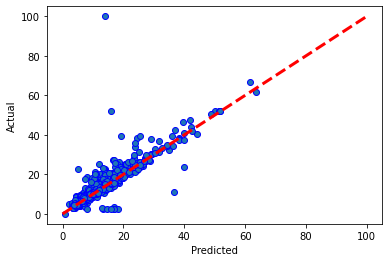

In [93]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots()
ax.scatter(y_predicted, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [92]:
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, y_predicted)
mse = metrics.mean_squared_error(y_test, y_predicted)
r2 = metrics.r2_score(y_test, y_predicted)

print("The model performance for testing set")
print("-------------------------------------")
print(f'MAE: {mae:.3}')
print(f'MSE: {mse:.3}')
print(f'R2:  {r2:.3}')

The model performance for testing set
-------------------------------------
MAE: 1.7
MSE: 17.2
R2:  0.779
